In [1]:
!pip install ultralytics

  Using cached py_cpuinfo-9.0.0-py3-none-any.whl.metadata (794 bytes)
  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached ultralytics_thop-2.0.14-py3-none-any.whl.metadata (9.4 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.8 MB/s eta 0:00:00a 0:00:01
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)
Using cached ultralytics_thop-2.0.14-py3-none-any.whl (26 kB)
Using cached py_cpuinfo-9.0.0-py3-none-any.whl (22 kB)


In [31]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import SAM
from PIL import Image


class SAMSegmentor:
    def __init__(self, model_path='sam2.1_b.pt'):
        self.model = SAM(model_path)

    def load_image(self, image_path):
        image = cv2.imread(image_path)
        if image is None:
            raise FileNotFoundError(f"Image not found: {image_path}")
        return image

    def load_yolo_label(self, label_path, image_shape):
        height, width = image_shape[:2]
        with open(label_path, 'r') as f:
            lines = f.readlines()
        bboxes = []
        for line in lines:
            parts = line.strip().split()
            if len(parts) != 5:
                continue
            _, x_center, y_center, w, h = map(float, parts)
            x1 = int((x_center - w / 2) * width)
            y1 = int((y_center - h / 2) * height)
            x2 = int((x_center + w / 2) * width)
            y2 = int((y_center + h / 2) * height)
            bboxes.append([x1, y1, x2, y2])
        return bboxes

    def segment(self, image, bboxes):
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        results = self.model.predict(image_rgb, bboxes=bboxes)
        combined_mask = np.zeros(image.shape[:2], dtype=np.uint8)
        for result in results:
            if result.masks is not None:
                for mask in result.masks.data:
                    mask_np = mask.cpu().numpy().astype(np.uint8)
                    combined_mask = np.maximum(combined_mask, mask_np)
        return image_rgb, combined_mask

    def extract_foreground_background(self, image_rgb, mask):
        # Ensure the mask is binary
        binary_mask = (mask > 0).astype(np.uint8) * 255

        # Create foreground by applying the mask
        foreground = cv2.bitwise_and(image_rgb, image_rgb, mask=binary_mask)

        # Create background: white where mask is present, original image elsewhere
        background = image_rgb.copy()
        background[binary_mask == 255] = [0,0,0]#[255, 255, 255]

        return foreground, background


    def plot_results(self, image_rgb, mask, foreground, background):
        fig, axs = plt.subplots(1, 4, figsize=(20, 5))
        axs[0].imshow(image_rgb)
        axs[0].set_title('Original Image')
        axs[0].axis('off')

        axs[1].imshow(mask, cmap='gray')
        axs[1].set_title('Segmentation Mask')
        axs[1].axis('off')

        axs[2].imshow(foreground)
        axs[2].set_title('Foreground')
        axs[2].axis('off')

        axs[3].imshow(background)
        axs[3].set_title('Background')
        axs[3].axis('off')

        plt.tight_layout()
        plt.show()

    def save_individual_foregrounds(self, image_rgb, results, save_dir="outputs/foregrounds"):
        os.makedirs(save_dir, exist_ok=True)
        count = 0
        for result in results:
            if result.masks is not None:
                for i, mask in enumerate(result.masks.data):
                    mask_np = mask.cpu().numpy().astype(np.uint8)
                    binary_mask = (mask_np > 0).astype(np.uint8)

                    ys, xs = np.where(binary_mask == 1)
                    if len(xs) == 0 or len(ys) == 0:
                        continue
                    x1, x2 = xs.min(), xs.max()
                    y1, y2 = ys.min(), ys.max()

                    crop_img = image_rgb[y1:y2+1, x1:x2+1]
                    crop_mask = binary_mask[y1:y2+1, x1:x2+1]
                    fg_crop = cv2.bitwise_and(crop_img, crop_img, mask=crop_mask)

                    out_path = os.path.join(save_dir, f"foreground_{count}.png")
                    cv2.imwrite(out_path, cv2.cvtColor(fg_crop, cv2.COLOR_RGB2BGR))
                    count += 1

    def save_background(self, image_rgb, results, save_path="outputs/background"):
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        combined_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)

        for result in results:
            if result.masks is not None:
                for mask in result.masks.data:
                    mask_np = mask.cpu().numpy().astype(np.uint8)
                    combined_mask = np.maximum(combined_mask, mask_np)

        # Create background image: white where mask == 1
        background = image_rgb.copy()
        background[combined_mask == 1] = [0, 0, 0]

        cv2.imwrite(save_path, cv2.cvtColor(background, cv2.COLOR_RGB2BGR))


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 43.1ms
Speed: 2.2ms preprocess, 43.1ms inference, 0.7ms postprocess per image at shape (1, 3, 1024, 1024)


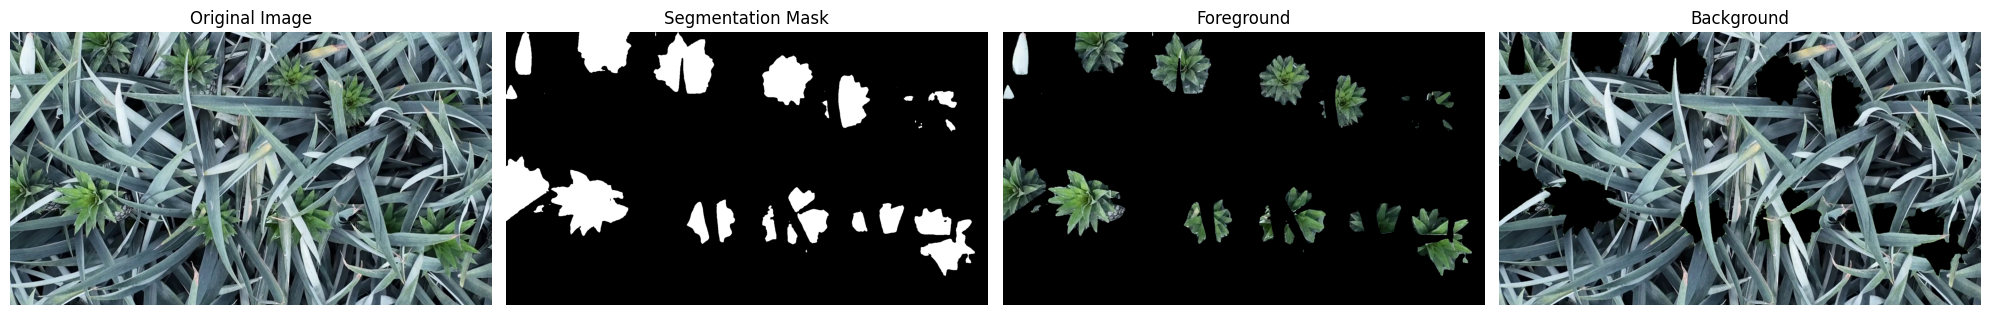


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 49.1ms
Speed: 2.3ms preprocess, 49.1ms inference, 0.5ms postprocess per image at shape (1, 3, 1024, 1024)


In [32]:
# Paths
image_path = '/home/rtxmsi1/Documents/VAE_training-master/DJI_20240308110115_0005_V/train/images/0b26b061.png'
label_path = '/home/rtxmsi1/Documents/VAE_training-master/DJI_20240308110115_0005_V/train/labels/0b26b061.txt'

# Initialize segmentor
segmentor = SAMSegmentor()

# Process
image = segmentor.load_image(image_path)
bboxes = segmentor.load_yolo_label(label_path, image.shape)
image_rgb, mask = segmentor.segment(image, bboxes)
foreground, background = segmentor.extract_foreground_background(image_rgb, mask)

# Plot
segmentor.plot_results(image_rgb, mask, foreground, background)
results = segmentor.model.predict(image_rgb, bboxes=bboxes)

In [33]:
segmentor.save_individual_foregrounds(image_rgb, results, save_dir="outputs/foreground")
segmentor.save_background(image_rgb, results, save_path="outputs/background/b.png")

In [40]:
import os
import cv2
import uuid
import numpy as np
from ultralytics import SAM

class SAMSegmentor:
    def __init__(self, model_name="sam2.1_b.pt"):
        self.model = SAM(model_name)

    def load_image(self, image_path):
        return cv2.imread(image_path)

    def load_yolo_label(self, label_path, image_shape):
        h, w = image_shape[:2]
        bboxes = []
        with open(label_path, "r") as file:
            for line in file:
                _, cx, cy, bw, bh = map(float, line.strip().split())
                x1 = int((cx - bw / 2) * w)
                y1 = int((cy - bh / 2) * h)
                x2 = int((cx + bw / 2) * w)
                y2 = int((cy + bh / 2) * h)
                bboxes.append([x1, y1, x2, y2])
        return bboxes

    def segment(self, image_rgb, bboxes):
        return self.model.predict(image_rgb, bboxes=bboxes)

    def save_foregrounds(self, image_rgb, results, image_name, save_dir):
        os.makedirs(save_dir, exist_ok=True)
        base = os.path.splitext(image_name)[0]

        for result in results:
            if result.masks is not None:
                for mask in result.masks.data:
                    mask_np = mask.cpu().numpy().astype(np.uint8)
                    binary_mask = (mask_np > 0).astype(np.uint8)

                    ys, xs = np.where(binary_mask == 1)
                    if len(xs) == 0 or len(ys) == 0:
                        continue
                    x1, x2 = xs.min(), xs.max()
                    y1, y2 = ys.min(), ys.max()

                    crop_img = image_rgb[y1:y2+1, x1:x2+1]
                    crop_mask = binary_mask[y1:y2+1, x1:x2+1]
                    fg_crop = cv2.bitwise_and(crop_img, crop_img, mask=crop_mask)

                    uid = str(uuid.uuid4())[:8]
                    out_path = os.path.join(save_dir, f"{base}_fg_{uid}.png")
                    cv2.imwrite(out_path, cv2.cvtColor(fg_crop, cv2.COLOR_RGB2BGR))

    def save_background(self, image_rgb, results, image_name, save_dir):
        os.makedirs(save_dir, exist_ok=True)
        combined_mask = np.zeros(image_rgb.shape[:2], dtype=np.uint8)

        for result in results:
            if result.masks is not None:
                for mask in result.masks.data:
                    mask_np = mask.cpu().numpy().astype(np.uint8)
                    combined_mask = np.maximum(combined_mask, mask_np)

        background = image_rgb.copy()
        background[combined_mask == 1] = [0,0,0]#[255, 255, 255]
        out_path = os.path.join(save_dir, f"{os.path.splitext(image_name)[0]}_bg.png")
        cv2.imwrite(out_path, cv2.cvtColor(background, cv2.COLOR_RGB2BGR))


def process_folder(image_folder, label_folder, output_root):
    segmentor = SAMSegmentor()

    for fname in os.listdir(image_folder):
        if not fname.lower().endswith((".png", ".jpg", ".jpeg")):
            continue

        image_path = os.path.join(image_folder, fname)
        label_path = os.path.join(label_folder, os.path.splitext(fname)[0] + ".txt")

        if not os.path.exists(label_path):
            print(f"[Warning] No label found for: {fname}")
            continue

        image = segmentor.load_image(image_path)
        if image is None:
            print(f"[Error] Could not load image: {image_path}")
            continue

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        bboxes = segmentor.load_yolo_label(label_path, image.shape)
        results = segmentor.segment(image_rgb, bboxes)

        segmentor.save_foregrounds(image_rgb, results, fname, os.path.join(output_root, "foregrounds"))
        segmentor.save_background(image_rgb, results, fname, os.path.join(output_root, "backgrounds"))
        print(f"[✓] Processed: {fname}")


if __name__ == "__main__":
    image_folder = "/home/rtxmsi1/Documents/VAE_training-master/DJI_20240308110115_0005_V/train/images"
    label_folder = "/home/rtxmsi1/Documents/VAE_training-master/DJI_20240308110115_0005_V/train/labels"
    output_root = "outputs"

    process_folder(image_folder, label_folder, output_root)



0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 45.1ms
Speed: 2.4ms preprocess, 45.1ms inference, 0.4ms postprocess per image at shape (1, 3, 1024, 1024)
[✓] Processed: 8706e094.png

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 45.2ms
Speed: 2.3ms preprocess, 45.2ms inference, 0.3ms postprocess per image at shape (1, 3, 1024, 1024)
[✓] Processed: 7da2b2bb.png

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 54.2ms
Speed: 2.3ms preprocess, 54.2ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
[✓] Processed: ee9c04f0.png

0: 1024x1024 1 0, 1 1, 1 2, 43.4ms
Speed: 2.2ms preprocess, 43.4ms inference, 0.3ms postprocess per image at shape (1, 3, 1024, 1024)
[✓] Processed: 87525285.png

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 51.4ms
Speed: 2.4ms preprocess, 51.4ms inference, 0.8ms postprocess per image at shape (1, 3, 1024, 1024)
[✓] Processed: 